In [1]:
import os

import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('pgf', rcfonts=False, preamble=r'''
    \usepackage[fontsize=10pt]{scrextend}
    \usepackage{unicode-math}
''') # https://github.com/matplotlib/matplotlib/issues/26892

In [2]:
rpc_filenames = os.listdir("data/rpc")
rpc_months = []
for rpc_filename in tqdm(rpc_filenames):
    rpc_months.append(pd.read_csv("data/rpc/" + rpc_filename, delimiter=";", dtype={"journey_start_insee": str , "journey_end_insee": str, "journey_start_department": str , "journey_end_department": str}))
rpc = pd.concat(rpc_months, ignore_index=True)

100%|███████████████████████████████████████████| 56/56 [00:55<00:00,  1.02it/s]


In [3]:
rpc["journey_month"] = rpc["journey_start_datetime"].str[:7]
step = "journey_month"
rpc["journey_distance_km"] = rpc["journey_distance"] / 1000
dists = rpc.groupby(step)["journey_distance_km"].sum().values
counts = rpc.groupby(step)["journey_id"].count().values
x = np.arange(rpc[step].unique().shape[0]) + 1

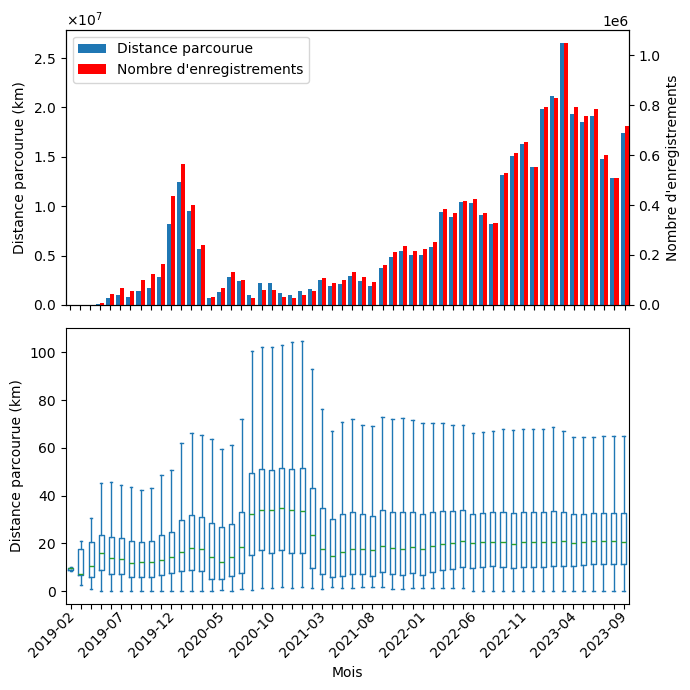

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(7,7))

bar1 = axes[0].bar(x-.2, dists, width=.4, label="Distance parcourue")
ax_twin = axes[0].twinx()
bar2 = ax_twin.bar(x+.2, counts, width=.4, color="red", label="Nombre d'enregistrements")
ax_twin.set_ylabel("Nombre d'enregistrements")
axes[0].set_ylabel("Distance parcourue (km)")
axes[0].ticklabel_format(axis="y", useMathText=True)
axes[0].xaxis.set_major_locator(mtick.FixedLocator(x))
axes[0].set_xticks(x)
axes[0].margins(x=0)

bars = bar1, bar2
labs = [l.get_label() for l in bars]
axes[0].legend(bars, labs, loc=0)

[l.set_visible(False) for (i,l) in enumerate(axes[0].xaxis.get_ticklabels())]

rpc[["journey_distance_km", step]].plot(kind="box", column="journey_distance_km", by=step, flierprops={"markersize": .5}, xlabel="Mois", ylabel="Distance parcourue (km)", title="", showfliers=False, ax=axes[1])
axes[1].set_xticks(x, sorted(rpc["journey_month"].unique()), rotation=45, ha="right", va="center_baseline", rotation_mode='anchor')
[l.set_visible(False) for (i,l) in enumerate(axes[1].xaxis.get_ticklabels()) if i % 5 != 0]
axes[1].set_title("")
axes[1].margins(x=.01)

plt.tight_layout()
plt.savefig("figures/rpc_month_distance_stats.pgf", bbox_inches='tight')

In [5]:
modal_shares = pd.read_excel("data/ip1835.xlsx", header=2, index_col=0, nrows=30, usecols="A:F")
modal_shares.rename({modal_shares.index[-1]: "$>$ 50"}, inplace=True)
modal_shares.columns = ("À pied", "Vélo", "Deux-roues motorisés", "Voiture", "TC")

bins = np.array(list(range(25)) + list([25, 30, 35, 40, 50, np.inf]))
trips_per_dist = pd.cut(rpc["journey_distance"] / 1000, bins, include_lowest=True).value_counts(sort=False)
trips_per_dist.index = modal_shares.index
multiplied = modal_shares.divide(100).mul(trips_per_dist, axis=0)

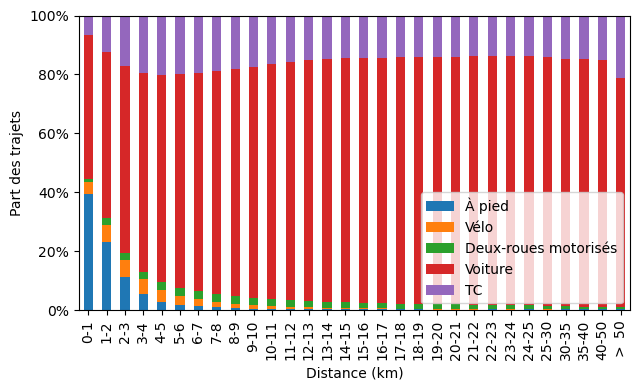

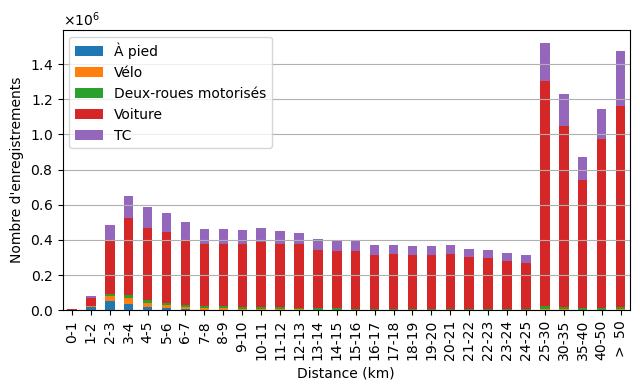

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6.5,4))
modal_shares.plot(kind="bar", stacked=True, ax=ax, xlabel="Distance (km)", ylabel="Part des trajets")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim(top=100)
plt.tight_layout()
plt.savefig("figures/parts_modales.pgf", bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(6.5,4))
multiplied.plot(kind="bar", stacked=True, ax=ax, xlabel="Distance (km)", ylabel="Nombre d'enregistrements")
ax.grid(axis="y")
ax.ticklabel_format(axis="y", useMathText=True)
ax.legend()

plt.tight_layout()
plt.savefig("figures/parts_modales_appliquees.pgf", bbox_inches='tight')
plt.show()

In [7]:
rpc_shares = (multiplied.sum() / rpc.shape[0]).rename("rpc_shares")

In [8]:
commute_shares = pd.Series({
    "À pied": 6.3,
    "Vélo": 2.2,
    "Deux-roues motorisés": 2.0,
    "Voiture": 73.7,
    "TC": 15.8
}, name="commute_shares") / 100

In [9]:
all_shares = pd.merge(rpc_shares, commute_shares, left_index=True, right_index=True)

In [10]:
all_shares.sum(axis=1)

À pied                  0.074952
Vélo                    0.032835
Deux-roues motorisés    0.036766
Voiture                 1.534628
TC                      0.320819
dtype: float64

Pandas(Index='À pied', rpc_shares=0.011952249160474247, commute_shares=0.063)
(0, 0)
Pandas(Index='Vélo', rpc_shares=0.01083500490087018, commute_shares=0.022000000000000002)
(0.063, 0.011952249160474247)
Pandas(Index='Deux-roues motorisés', rpc_shares=0.01676576437321815, commute_shares=0.02)
(0.085, 0.022787254061344426)
Pandas(Index='Voiture', rpc_shares=0.7976281995903513, commute_shares=0.737)
(0.10500000000000001, 0.039553018434562576)
Pandas(Index='TC', rpc_shares=0.16281878197508615, commute_shares=0.158)
(0.842, 0.8371812180249139)


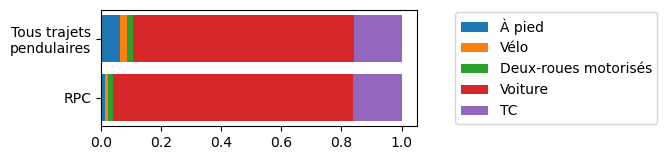

In [11]:
fig, ax = plt.subplots(figsize=(7,1.7))
last_height= (0, 0)
for a in all_shares.itertuples():
    print(a)
    print(last_height)
    ax.barh(["Tous trajets\npendulaires", "RPC"], (a.commute_shares, a.rpc_shares), left=last_height, label=a.Index)
    last_height = (last_height[0] + a.commute_shares, last_height[1] + a.rpc_shares)
ax.legend(loc="center left", bbox_to_anchor=(1.1,.5))
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("figures/compare_parts_modales.pgf", bbox_inches='tight')
plt.show()

In [12]:
rpc.shape[0]

16212427